## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

## Divisão dos dados em X e Y

Label Encoder do y & Normalização do X

In [3]:
dataset_path = 'feature_extraction.csv'
data = pd.read_csv(dataset_path)

X = data.drop(columns=['file_id', 'class', 'fold'])
y = data['class']

#One Hot Encoder de y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#Normalização de X
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(pd.DataFrame(X).head())
print(np.unique(y))

         0         1         2         3         4         5         6   \
0  0.683183  0.017093  0.621973  0.469777  0.383277  0.638431  0.505458   
1  0.718800  0.105597  0.460109  0.637143  0.377176  0.563590  0.472180   
2  0.728638  0.092748  0.416206  0.685898  0.283718  0.519607  0.469577   
3  0.478898  0.036833  0.516766  0.653926  0.260736  0.470929  0.489646   
4  0.496398  0.700244  0.422515  0.824047  0.313228  0.513074  0.495865   

         7         8         9   ...        13        14        15        16  \
0  0.035471  0.092136  0.036746  ...  0.077481  0.165125  0.026641  0.279333   
1  0.138060  0.186574  0.273884  ...  0.395330  0.385121  0.297618  0.668237   
2  0.104300  0.098335  0.046947  ...  0.325160  0.241995  0.111223  0.464770   
3  0.139243  0.087479  0.104135  ...  0.125955  0.218403  0.084630  0.418222   
4  0.135814  0.168407  0.233478  ...  0.402947  0.331131  0.254352  0.459972   

         17        18        19        20        21   22  
0  0.0266

## Definição dos folds de acordo com os folds dos dados originais

In [4]:
def get_train_val_test_splits(X, val_fold, test_fold):

    data['fold_number'] = data['fold'].str.extract('(\d+)').astype(int)

    val_indices = data[data['fold_number'] == val_fold].index
    test_indices = data[data['fold_number'] == test_fold].index

    train_indices = data[(data['fold_number'] != val_fold) &
                         (data['fold_number'] != test_fold)].index

    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

## PCA

Aplicação do PCA ao dataset extraído para evitar variáveis correlacionadas (e consequentemente overfitting). O número de componentes foi escolhido através do gráfico de variância acumulada à medida que se adicionam componentes ao PCA (10 componentes que explicam cerca de 90% da variância do dataset)

In [5]:
pca = PCA(n_components=10)
new_X = pca.fit_transform(X)

## Número de camadas escondidas

Duas camadas escondidas já são capazes de representar qualquer relação entre os dados, mesmo aquelas que não podem ser representadas por equações. Mais do que duas camadas escondidas só são necessárias em problemas ainda mais complexos como séries temporais e visão computacional, onde há uma certa inter-relação entre as dimensões que os dados contêm

In [6]:
n_camadas = [2, 3]
print ("Range do nº de camadas: ", n_camadas)

Range do nº de camadas:  [2, 3]


## Número de neurónios em cada camada escondida

Abordagens:  
O número de neurônios escondidos deve estar entre o tamanho da camada de entrada e o da camada de saída.  
O número de neurônios escondidos deve ser 2/3 do tamanho da camada de entrada, mais o tamanho da camada de saída

In [7]:
def n_neuronios(X):
    n_neur = [0] * 3
    input_dim = X.shape[1]
    output_dim = len(label_encoder.classes_)
    #Neurónios na camada escondida 1
    n_neur [0] = int((input_dim + output_dim)/2)
    #Neurónios na camada escondida 2
    n_neur [1] = int((input_dim + output_dim)/3)
    #Neurónios na camada escondida 3
    n_neur [2] = int((input_dim + output_dim)/4)
    return n_neur, output_dim

## Inicialização dos pesos

Função gaussiana para inicializar os pesos

In [8]:
def initialize_weights(shape, dtype=None):
    mean = 0.0
    stddev = 0.01
    return tf.constant(np.random.normal(loc=mean, scale=stddev, size=shape), dtype=dtype)

## Ajuste do Learning Rate ao longo da aprendizagem

Ajustar o Learning Rate para metade do seu valor de 10 em 10 epochs

In [9]:
def scheduler(epoch, lr):
    lr_scheduler = LearningRateScheduler(scheduler)
    if epoch > 0 and epoch % 10 == 0:
        return lr / 2
    return lr
lr_scheduler = LearningRateScheduler(scheduler)

## Early Stop

Verificar se a validation loss (no fold de desenvolvimento) não melhora em 10 epochs consecutivos, e para o treino caso isso aconteça

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Grid Search

Função que faz um grid search para encontrar o melhor learning rate para o otimizador Adam e o melhor número de epochs e batch size para o modelo. Os valores em cada grid foram pedidos ao ChatGPT. A cada modelo é aplicada uma 10-cross validation, com 8 folds a serem usados para treino, 1 para teste e 1 para desenvolvimento

In [33]:
def grid_search(model, X, y, data):
    learning_rate = [0.01, 0.001]
    epochs = [50, 100, 200]
    batch_size = [64, 128]
    best_model = None
    best_model_accuracy = 0
    
    log_file = "optimization_results_MLP.txt"
    with open(log_file, "w") as f:
        f.write("Resultados da Otimização Bayesiana\n\n")
        
    trial_number = 0
    for i in learning_rate:
        for j in epochs:
            for m in batch_size:
                
                trial_number += 1
                adam_optimizer = tf.keras.optimizers.Adam(learning_rate=i)
                model = model
                all_accuracies = []
                all_confusion_matrices = []
                all_losses = []

                for f in range (1, 11):
                    r = f+1
                    if r > 10:
                        r = 1

                    X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_splits(X, r, f)
                    model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

                    model.fit(X_train, y_train, epochs=j, batch_size=m, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

                    loss, accuracy = model.evaluate(X_val, y_val)

                    all_accuracies.append(accuracy)
                    y_pred = model.predict(X_val)
                    y_pred_classes = np.argmax(y_pred, axis=1)
                    cm = confusion_matrix(y_val, y_pred_classes)
                    all_confusion_matrices.append(cm)
                    all_losses.append(loss)

                accumulated_cm = np.sum(all_confusion_matrices, axis=0)
                accumulated_cm_percentage = accumulated_cm / np.sum(accumulated_cm) * 100
                mean_accuracy = np.mean(all_accuracies)
                mean_loss = np.mean(all_losses)

                with open(log_file, "a") as f:
                    f.write(f"Trial {trial_number}\n")
                    f.write(f"Learning Rate: {i}, Epochs: {j}\n")
                    f.write(f"Test Loss: {mean_loss}, Accuracy: {mean_accuracy}\n")
                    f.write(f"Confusion Matrix:\n{accumulated_cm_percentage}\n\n")
                    
                if best_model is None or mean_accuracy > best_model_accuracy:
                    best_model = model
                    best_model_accuracy = mean_accuracy
                    best_model_cfm = accumulated_cm_percentage
                    best_model_loss = mean_loss
                    best_model_lr = i
                    best_model_epochs = j
                    best_model_batch_size = m

    return best_model, best_model_accuracy, best_model_cfm, best_model_loss, best_model_lr, best_model_epochs, best_model_batch_size

## Escolha de funções de ativação

Para as camadas escondidas testámos modelos com funções de ativação ReLU e funções de ativação LeakyReLU  
"The ReLU function is the default activation function for hidden layers in modern MLP and CNN neural network models"  
"(The LeakyReLU function) does not have any linear component with zero derivatives (slopes). Therefore, it can avoid the dying ReLU problem"  
"The same usage of the ReLU function is also valid for the leaky ReLU function"  

Para as camadas de output usámos sempre a função de ativação softmax  
"We must use the softmax function in the output layer of a multiclass classification problem"

In [34]:
models = []

## MLP com 2 camadas escondidas e funções de ativação ReLU

In [35]:
def model1(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
        ])
    return model
models.append(model1)

## MLP com 2 camadas escondidas e funções de ativação LeakyReLU

In [36]:
def model2(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model2)

## MLP com 3 camadas escondidas e funções de ativação ReLU

In [37]:
def model3(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model3)

## MLP com 3 camadas escondidas e funções de ativação LeakyReLU

In [38]:
def model4(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model4)

## Encontrar o melhor modelo MLP

In [39]:
best_model = None
best_model_accuracy = 0
for model_func in models:
    n_neur, output_dim = n_neuronios(new_X)
    model = model_func(new_X, n_neur, output_dim)
    model, model_accuracy, model_cfm, model_loss, model_lr, model_epochs, model_batch_size = grid_search(model, new_X, y, data)
    if best_model == None or model_accuracy > best_model_accuracy:
        best_model = model
        best_model_accuracy = model_accuracy
        best_model_cfm = model_cfm
        best_model_loss = model_loss
        best_model_lr = model_lr
        best_model_epochs = model_epochs
        best_model_batch_size = model_batch_size

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1645 - loss: 2.1974 - val_accuracy: 0.2770 - val_loss: 1.9172 - learning_rate: 0.0100
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.3802 - loss: 1.6318 - val_accuracy: 0.3457 - val_loss: 1.7791 - learning_rate: 0.0100
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4189 - loss: 1.4631 - val_accuracy: 0.3288 - val_loss: 1.6214 - learning_rate: 0.0100
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4510 - loss: 1.3959 - val_accuracy: 0.3716 - val_loss: 1.5769 - learning_rate: 0.0100
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4925 - loss: 1.3346 - val_accuracy: 0.3930 - val_loss: 1.5529 - learning_rate: 0.0100
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4977 - loss: 1.3154 - val_accuracy: 0.3795 - val_loss: 1.5118 - learning_rate: 0.0100
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5200 - loss: 1.2794 

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6210 - loss: 1.0670 - val_accuracy: 0.5577 - val_loss: 1.2479 - learning_rate: 0.0100
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.6337 - loss: 1.0507 - val_accuracy: 0.5371 - val_loss: 1.2957 - learning_rate: 0.0100
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6326 - loss: 1.0445 - val_accuracy: 0.5249 - val_loss: 1.3275 - learning_rate: 0.0100
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6402 - loss: 1.0261 - val_accuracy: 0.4994 - val_loss: 1.3732 - learning_rate: 0.0100
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.6464 - loss: 1.0268 - val_accuracy: 0.5225 - val_loss: 1.3289 - learning_rate: 0.0100
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.6462 - loss: 1.0312 - val_accuracy: 0.5176 - val_loss: 1.3282 - learning_rate: 0.0100
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6374 - loss: 1.0278 - val_a

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6499 - loss: 1.0273 - val_accuracy: 0.6189 - val_loss: 1.0146 - learning_rate: 0.0100
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6503 - loss: 1.0255 - val_accuracy: 0.6117 - val_loss: 1.0566 - learning_rate: 0.0100
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6553 - loss: 1.0109 - val_accuracy: 0.6165 - val_loss: 1.0340 - learning_rate: 0.0100
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 1.0080 - val_accuracy: 0.5962 - val_loss: 1.0522 - learning_rate: 0.0100
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6704 - loss: 0.9723 - val_accuracy: 0.5974 - val_loss: 1.0677 - learning_rate: 0.0100
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6546 - loss: 0.9726 - val_accuracy: 0.6022 - val_loss: 1.0657 - learning_rate: 0.0100
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.6596 - loss: 0.9681 - val_acc

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6579 - loss: 1.0026 - val_accuracy: 0.6384 - val_loss: 1.0633 - learning_rate: 0.0100
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6563 - loss: 0.9975 - val_accuracy: 0.6242 - val_loss: 1.0870 - learning_rate: 0.0100
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6605 - loss: 0.9769 - val_accuracy: 0.6293 - val_loss: 1.1114 - learning_rate: 0.0100
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6659 - loss: 0.9609 - val_accuracy: 0.6192 - val_loss: 1.1570 - learning_rate: 0.0100
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 0.9793 - val_accuracy: 0.6172 - val_loss: 1.1379 - learning_rate: 0.0100
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6683 - loss: 0.9696 - val_accuracy: 0.6253 - val_loss: 1.1515 - learning_rate: 0.0100
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6692 - loss: 0.9684 - val_accuracy: 0.6232 - va

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6743 - loss: 0.9727 - val_accuracy: 0.6179 - val_loss: 1.0692 - learning_rate: 0.0050
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6614 - loss: 0.9836 - val_accuracy: 0.6141 - val_loss: 1.1295 - learning_rate: 0.0050
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6678 - loss: 0.9744 - val_accuracy: 0.6117 - val_loss: 1.1514 - learning_rate: 0.0050
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6812 - loss: 0.9453 - val_accuracy: 0.6055 - val_loss: 1.1435 - learning_rate: 0.0050
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6716 - loss: 0.9749 - val_accuracy: 0.6005 - val_loss: 1.1634 - learning_rate: 0.0050
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 0.9756 - val_accuracy: 0.6141 - val_loss: 1.2026 - learning_rate: 0.0050
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6513 - loss: 1.0192 - val_accuracy: 0.6295 - val_loss: 1.0221 - learning_rate: 0.0100
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.6561 - loss: 1.0136 - val_accuracy: 0.6047 - val_loss: 1.1237 - learning_rate: 0.0100
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6716 - loss: 0.9634 - val_accuracy: 0.5732 - val_loss: 1.1285 - learning_rate: 0.0100
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6672 - loss: 0.9989 - val_accuracy: 0.5462 - val_loss: 1.2380 - learning_rate: 0.0100
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6557 - loss: 1.0000 - val_accuracy: 0.5574 - val_loss: 1.1829 - learning_rate: 0.0100
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6544 - loss: 0.9974 - val_accuracy: 0.5405 - val_loss: 1.2263 - learning_rate: 0.0100
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.9867 -

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6727 - loss: 0.9809 - val_accuracy: 0.5261 - val_loss: 1.3649 - learning_rate: 0.0100
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6743 - loss: 0.9580 - val_accuracy: 0.5079 - val_loss: 1.4051 - learning_rate: 0.0100
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6692 - loss: 0.9657 - val_accuracy: 0.5225 - val_loss: 1.3829 - learning_rate: 0.0100
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6762 - loss: 0.9554 - val_accuracy: 0.5358 - val_loss: 1.3837 - learning_rate: 0.0100
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.6775 - loss: 0.9482 - val_accuracy: 0.5286 - val_loss: 1.3637 - learning_rate: 0.0100
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6752 - loss: 0.9517 - val_accuracy: 0.5407 - val_loss: 1.4183 - learning_rate: 0.0100
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.5917 - loss: 1.4308
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6766 - loss: 0.9806 - val_accuracy: 0.6332 - val_loss: 0.9919 - learning_rate: 0.0100
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.6701 - loss: 0.9539 - val_accuracy: 0.6428 - val_loss: 1.0515 - learning_rate: 0.0100
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.6655 - loss: 0.9677 - val_accuracy: 0.6320 - val_loss: 1.0560 - learning_rate: 0.0100
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6805 - loss: 0.9555 - val_accuracy: 0.6237 - val_loss: 1.0373 - learning_rate: 0.0100
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6763 - loss: 0.9690 - val_accuracy: 0.6308 - val_loss: 1.0582 - learning_rate: 0.0100
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6830 - loss: 0.9449 - val_accuracy: 0.6356 - val_

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.6436 - loss: 1.0236
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 0.9712 - val_accuracy: 0.6263 - val_loss: 1.0847 - learning_rate: 0.0100
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6755 - loss: 0.9456 - val_accuracy: 0.6303 - val_loss: 1.1415 - learning_rate: 0.0100
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6617 - loss: 0.9770 - val_accuracy: 0.6404 - val_loss: 1.1203 - learning_rate: 0.0100
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.9402 - val_accuracy: 0.6333 - val_loss: 1.1409 - learning_rate: 0.0100
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6752 - loss: 0.9459 - val_accuracy: 0.6394 - val_loss: 1.1474 - learning_rate: 0.0100
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6791 - loss: 0.9345 - val_accuracy: 0.6242 - val_loss: 1.1866 - l

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6617 - loss: 0.9789 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6774 - loss: 0.9652 - val_accuracy: 0.6079 - val_loss: 1.0912 - learning_rate: 0.0100
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6843 - loss: 0.9455 - val_accuracy: 0.6017 - val_loss: 1.1257 - learning_rate: 0.0100
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6793 - loss: 0.9536 - val_accuracy: 0.5931 - val_loss: 1.1890 - learning_rate: 0.0100
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6872 - loss: 0.9534 - val_accuracy: 0.5881 - val_loss: 1.2522 - learning_rate: 0.0100
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6803 - loss: 0.9559 - val_accuracy: 0.6104 - val_loss: 1.2159 - learning_rate: 0.0100
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6747 - loss: 0.9550 - val_accuracy: 0.5868 - val_loss: 1.2183 - lea

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.6936 - loss: 0.9679
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6670 - loss: 0.9796 - val_accuracy: 0.6329 - val_loss: 1.0174 - learning_rate: 0.0100
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.6780 - loss: 0.9502 - val_accuracy: 0.5766 - val_loss: 1.1340 - learning_rate: 0.0100
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6694 - loss: 0.9649 - val_accuracy: 0.5676 - val_loss: 1.1076 - learning_rate: 0.0100
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6876 - loss: 0.9472 - val_accuracy: 0.5800 - val_loss: 1.2153 - learning_rate: 0.0100
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.6729 - loss: 0.9728 - val_accuracy: 0.5709 - val_loss: 1.1803 - learning_rate: 0.0100
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6824 - loss: 0.9509 - val_accuracy: 0.5766 - 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6009 - loss: 1.1093
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6634 - loss: 1.0125 - val_accuracy: 0.5213 - val_loss: 1.2623 - learning_rate: 0.0100
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6709 - loss: 0.9726 - val_accuracy: 0.5541 - val_loss: 1.2829 - learning_rate: 0.0100
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6836 - loss: 0.9440 - val_accuracy: 0.5589 - val_loss: 1.3142 - learning_rate: 0.0100
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6776 - loss: 0.9552 - val_accuracy: 0.5480 - val_loss: 1.3421 - learning_rate: 0.0100
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.6836 - loss: 0.9686 - val_accuracy: 0.5200 - val_loss: 1.3711 - learning_rate: 0.0100
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6824 - loss: 0.9439 - val_accuracy: 0.5431 - val_lo

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5772 - loss: 1.3383 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6830 - loss: 0.9684 - val_accuracy: 0.6416 - val_loss: 0.9751 - learning_rate: 0.0100
Epoch 2/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6759 - loss: 0.9436 - val_accuracy: 0.6249 - val_loss: 0.9856 - learning_rate: 0.0100
Epoch 3/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.6736 - loss: 0.9640 - val_accuracy: 0.6320 - val_loss: 1.0297 - learning_rate: 0.0100
Epoch 4/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6825 - loss: 0.9590 - val_accuracy: 0.6284 - val_loss: 1.0260 - learning_rate: 0.0100
Epoch 5/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6735 - loss: 0.9492 - val_accuracy: 0.6033 - val_loss: 1.0596 - learning_rate: 0.0100
Epoch 6/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6767 - loss: 0.9664 - val_accuracy: 0.6201 - val_lo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.6639 - loss: 0.9592
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6652 - loss: 0.9581 - val_accuracy: 0.6556 - val_loss: 1.0557 - learning_rate: 0.0100
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6706 - loss: 0.9388 - val_accuracy: 0.6545 - val_loss: 1.0888 - learning_rate: 0.0100
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6793 - loss: 0.9209 - val_accuracy: 0.6424 - val_loss: 1.1296 - learning_rate: 0.0100
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.9116 - val_accuracy: 0.6273 - val_loss: 1.1795 - learning_rate: 0.0100
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.9353 - val_accuracy: 0.6354 - val_loss: 1.1557 - learning_rate: 0.0100
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6715 - loss: 0.9304 - val_accuracy: 0.6323 - val_loss: 1.1964 - l

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.6394 - loss: 1.0170
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6781 - loss: 0.9576 - val_accuracy: 0.6179 - val_loss: 1.0736 - learning_rate: 0.0100
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6752 - loss: 0.9653 - val_accuracy: 0.6067 - val_loss: 1.1324 - learning_rate: 0.0100
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6802 - loss: 0.9418 - val_accuracy: 0.6017 - val_loss: 1.1304 - learning_rate: 0.0100
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6838 - loss: 0.9354 - val_accuracy: 0.5993 - val_loss: 1.1577 - learning_rate: 0.0100
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6856 - loss: 0.9268 - val_accuracy: 0.6104 - val_loss: 1.1531 - learning_rate: 0.0100
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6787 - loss: 0.9651 - val_accuracy: 0.5931 - val_loss: 1.2149 -

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.6649 - loss: 0.9123
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6700 - loss: 0.9539 - val_accuracy: 0.6678 - val_loss: 0.9626 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6768 - loss: 0.9404 - val_accuracy: 0.6802 - val_loss: 0.9828 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6765 - loss: 0.9438 - val_accuracy: 0.6779 - val_loss: 1.0029 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6775 - loss: 0.9439 - val_accuracy: 0.6644 - val_loss: 1.0192 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6807 - loss: 0.9312 - val_accuracy: 0.6543 - val_loss: 1.0258 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6752 - loss: 0.9510 - val_accuracy: 0.6554 - val_loss: 1.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.6534 - loss: 0.9665
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6789 - loss: 0.9382 - val_accuracy: 0.6039 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6843 - loss: 0.9398 - val_accuracy: 0.5881 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.6933 - loss: 0.9230 - val_accuracy: 0.5930 - val_loss: 1.1384 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6932 - loss: 0.9303 - val_accuracy: 0.5881 - val_loss: 1.1471 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.6887 - loss: 0.9339 - val_accuracy: 0.5820 - val_loss: 1.1584 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6890 - loss: 0.9084 - val_accuracy: 0.5869 - val_loss

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.6691 - loss: 1.1130
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6966 - loss: 0.9306 - val_accuracy: 0.6643 - val_loss: 0.9201 - learning_rate: 0.0010
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6896 - loss: 0.9385 - val_accuracy: 0.6511 - val_loss: 0.9406 - learning_rate: 0.0010
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6941 - loss: 0.9195 - val_accuracy: 0.6487 - val_loss: 0.9441 - learning_rate: 0.0010
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6953 - loss: 0.9409 - val_accuracy: 0.6452 - val_loss: 0.9520 - learning_rate: 0.0010
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6904 - loss: 0.9223 - val_accuracy: 0.6452 - val_loss: 0.9655 - learning_rate: 0.0010
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.6985 - loss: 0.9065 - val_accuracy: 0.6452 - val_loss: 0.

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6796 - loss: 0.9354 - val_accuracy: 0.6962 - val_loss: 0.9504 - learning_rate: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7530 - loss: 0.8177
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 0.9288 - val_accuracy: 0.6697 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6724 - loss: 0.9389 - val_accuracy: 0.6525 - val_loss: 0.9996 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6806 - loss: 0.9232 - val_accuracy: 0.6525 - val_loss: 1.0157 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6820 - loss: 0.9169 - val_accuracy: 0.6485 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6854 - loss: 0.9152 - val_accuracy: 0.6495 - val_loss: 1.0324 - learning_rate: 0.0

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6978 - loss: 0.9157 - val_accuracy: 0.6862 - val_loss: 0.9411 - learning_rate: 0.0010
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.6754 - loss: 0.9321
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6868 - loss: 0.9398 - val_accuracy: 0.6551 - val_loss: 1.0191 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6903 - loss: 0.9353 - val_accuracy: 0.6476 - val_loss: 1.0319 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6872 - loss: 0.9413 - val_accuracy: 0.6439 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6878 - loss: 0.9243 - val_accuracy: 0.6427 - val_loss: 1.0646 - learning_rate: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6985 - loss: 0.9056 - val_accuracy: 0.6340 - val_loss: 1.0762 - learning_rate: 0.0

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6931 - loss: 0.9248 - val_accuracy: 0.6930 - val_loss: 0.8882 - learning_rate: 0.0010
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6902 - loss: 0.9363 - val_accuracy: 0.6964 - val_loss: 0.8873 - learning_rate: 5.0000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7199 - loss: 0.8219
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6720 - loss: 0.9615 - val_accuracy: 0.7038 - val_loss: 0.9376 - learning_rate: 0.0010
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 0.9499 - val_accuracy: 0.6937 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6895 - loss: 0.9221 - val_accuracy: 0.6847 - val_loss: 0.9854 - learning_rate: 0.0010
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6740 - loss: 0.9634 - val_accuracy: 0.6667 - val_loss: 1.0127 - l

Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6937 - loss: 0.9155 - val_accuracy: 0.6891 - val_loss: 0.9256 - learning_rate: 0.0010
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6836 - loss: 0.9257 - val_accuracy: 0.6795 - val_loss: 0.9314 - learning_rate: 0.0010
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.6542 - loss: 0.9693
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6856 - loss: 0.9324 - val_accuracy: 0.6087 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6954 - loss: 0.9151 - val_accuracy: 0.5966 - val_loss: 1.1284 - learning_rate: 0.0010
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6978 - loss: 0.9326 - val_accuracy: 0.6027 - val_loss: 1.1341 - learning_rate: 0.0010
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6914 - loss: 0.9353 - val_accuracy: 0.5942 - val_los

Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6933 - loss: 0.9061 - val_accuracy: 0.6458 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6872 - loss: 0.9260 - val_accuracy: 0.6458 - val_loss: 1.0933 - learning_rate: 0.0010
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.6622 - loss: 1.1117
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6908 - loss: 0.9414 - val_accuracy: 0.6643 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6977 - loss: 0.9232 - val_accuracy: 0.6535 - val_loss: 0.9381 - learning_rate: 0.0010
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7001 - loss: 0.9243 - val_accuracy: 0.6535 - val_loss: 0.9329 - learning_rate: 0.0010
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6929 - loss: 0.9169 - val_accuracy: 0.6499 - val_l

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.9291 - val_accuracy: 0.7124 - val_loss: 0.9446 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6876 - loss: 0.9357 - val_accuracy: 0.6995 - val_loss: 0.9510 - learning_rate: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.7567 - loss: 0.8240
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6822 - loss: 0.9402 - val_accuracy: 0.6677 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6802 - loss: 0.9405 - val_accuracy: 0.6626 - val_loss: 1.0061 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6724 - loss: 0.9184 - val_accuracy: 0.6586 - val_loss: 1.0169 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6911 - loss: 0.9026 - val_accuracy: 0.6576 - val_loss: 1.0249 - learning_rat

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6901 - loss: 0.9308 - val_accuracy: 0.6874 - val_loss: 0.9373 - learning_rate: 0.0010
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6951 - loss: 0.9009 - val_accuracy: 0.6790 - val_loss: 0.9432 - learning_rate: 0.0010
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.6658 - loss: 0.9320
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6939 - loss: 0.9278 - val_accuracy: 0.6501 - val_loss: 1.0180 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6928 - loss: 0.9203 - val_accuracy: 0.6476 - val_loss: 1.0467 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6870 - loss: 0.9417 - val_accuracy: 0.6501 - val_loss: 1.0475 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6885 - loss: 0.9383 - val_accuracy: 0.6464 - val_loss: 1.0644 - learning_rat

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6849 - loss: 0.9552 - val_accuracy: 0.7045 - val_loss: 0.8775 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6883 - loss: 0.9432 - val_accuracy: 0.7010 - val_loss: 0.8796 - learning_rate: 0.0010
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6785 - loss: 0.9569 - val_accuracy: 0.6964 - val_loss: 0.8829 - learning_rate: 5.0000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.7190 - loss: 0.8183
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6807 - loss: 0.9476 - val_accuracy: 0.6926 - val_loss: 0.9451 - learning_rate: 0.0010
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6701 - loss: 0.9673 - val_accuracy: 0.6971 - val_loss: 0.9695 - learning_rate: 0.0010
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6866 - loss: 0.9273 - val_accuracy: 0.6712 - val_loss: 0.9896 - l

Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 0.9384 - val_accuracy: 0.6859 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6899 - loss: 0.9229 - val_accuracy: 0.6763 - val_loss: 0.9341 - learning_rate: 0.0010
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7016 - loss: 0.8970 - val_accuracy: 0.6774 - val_loss: 0.9378 - learning_rate: 0.0010
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6563 - loss: 0.9728 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6890 - loss: 0.9330 - val_accuracy: 0.6173 - val_loss: 1.0903 - learning_rate: 0.0010
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6932 - loss: 0.9255 - val_accuracy: 0.5990 - val_loss: 1.1154 - learning_rate: 0.0010
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6970 - loss: 0.9300 - val_accuracy: 0.5930 - val_loss

Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7040 - loss: 0.8959 - val_accuracy: 0.6544 - val_loss: 1.0723 - learning_rate: 0.0010
Epoch 9/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6969 - loss: 0.9004 - val_accuracy: 0.6483 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 10/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6890 - loss: 0.9261 - val_accuracy: 0.6556 - val_loss: 1.0752 - learning_rate: 0.0010
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.6784 - loss: 1.0878
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6890 - loss: 0.9429 - val_accuracy: 0.6559 - val_loss: 0.9328 - learning_rate: 0.0010
Epoch 2/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.6752 - loss: 0.9453 - val_accuracy: 0.6559 - val_loss: 0.9287 - learning_rate: 0.0010
Epoch 3/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7005 - loss: 0.9077 - val_accuracy: 0.6511 - val

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6782 - loss: 0.9261 - val_accuracy: 0.7081 - val_loss: 0.9454 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6802 - loss: 0.9358 - val_accuracy: 0.6973 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6781 - loss: 0.9351 - val_accuracy: 0.7049 - val_loss: 0.9534 - learning_rate: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.7595 - loss: 0.8306
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6767 - loss: 0.9489 - val_accuracy: 0.6626 - val_loss: 0.9906 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6858 - loss: 0.9242 - val_accuracy: 0.6636 - val_loss: 1.0034 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6859 - loss: 0.9217 - val_accuracy: 0.6616 - val_loss: 1.0154 - learning_rat

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6933 - loss: 0.9144 - val_accuracy: 0.6862 - val_loss: 0.9317 - learning_rate: 0.0010
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6914 - loss: 0.9236 - val_accuracy: 0.6897 - val_loss: 0.9379 - learning_rate: 0.0010
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6882 - loss: 0.9265 - val_accuracy: 0.6862 - val_loss: 0.9364 - learning_rate: 0.0010
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.6770 - loss: 0.9247
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6820 - loss: 0.9609 - val_accuracy: 0.6464 - val_loss: 1.0155 - learning_rate: 0.0010
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6975 - loss: 0.9075 - val_accuracy: 0.6464 - val_loss: 1.0379 - learning_rate: 0.0010
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6871 - loss: 0.9475 - val_accuracy: 0.6452 - val_loss: 1.0470 - learning_rat

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6939 - loss: 0.9366 - val_accuracy: 0.7102 - val_loss: 0.8650 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6822 - loss: 0.9392 - val_accuracy: 0.7090 - val_loss: 0.8694 - learning_rate: 0.0010
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6888 - loss: 0.9242 - val_accuracy: 0.6999 - val_loss: 0.8778 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7235 - loss: 0.8188 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1361 - loss: 2.1747 - val_accuracy: 0.1329 - val_loss: 1.9833 - learning_rate: 0.0100
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2535 - loss: 1.7910 - val_accuracy: 0.2658 - val_loss: 1.9637 - learning_rate: 0.0100
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.3396 - loss: 1.6460 - val_accuracy: 0.3266 - val_loss: 1.6457 - learning

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6164 - loss: 1.0553 - val_accuracy: 0.6122 - val_loss: 1.1012 - learning_rate: 0.0100
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6255 - loss: 1.0413 - val_accuracy: 0.6464 - val_loss: 1.0651 - learning_rate: 0.0100
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6258 - loss: 1.0335 - val_accuracy: 0.6667 - val_loss: 1.0517 - learning_rate: 0.0100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.6176 - loss: 1.1635
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6248 - loss: 1.0483 - val_accuracy: 0.5553 - val_loss: 1.1904 - learning_rate: 0.0100
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6305 - loss: 1.0409 - val_accuracy: 0.5322 - val_loss: 1.2067 - learning_rate: 0.0100
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6450 - loss: 1.0131 - val_accuracy: 0.5431 - val_loss: 1.2245 - l

Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.6546 - loss: 0.9985 - val_accuracy: 0.5404 - val_loss: 1.3437 - learning_rate: 0.0100
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6555 - loss: 1.0052 - val_accuracy: 0.5319 - val_loss: 1.3830 - learning_rate: 0.0100
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6426 - loss: 1.0201 - val_accuracy: 0.5637 - val_loss: 1.3566 - learning_rate: 0.0100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.5635 - loss: 1.3608
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6520 - loss: 1.0247 - val_accuracy: 0.5830 - val_loss: 1.1271 - learning_rate: 0.0100
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6569 - loss: 0.9850 - val_accuracy: 0.5783 - val_loss: 1.1539 - learning_rate: 0.0100
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6616 - loss: 0.9959 - val_accuracy: 0.5317 - val_loss: 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6525 - loss: 0.9937 - val_accuracy: 0.5881 - val_loss: 1.2253 - learning_rate: 0.0100
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6439 - loss: 1.0159 - val_accuracy: 0.5849 - val_loss: 1.2306 - learning_rate: 0.0100
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 1.0064 - val_accuracy: 0.5816 - val_loss: 1.2340 - learning_rate: 0.0100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.6412 - loss: 1.0600
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6318 - loss: 1.0364 - val_accuracy: 0.6495 - val_loss: 1.0499 - learning_rate: 0.0100
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 1.0064 - val_accuracy: 0.6444 - val_loss: 1.0659 - learning_rate: 0.0100
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 1.0036 - val_accuracy: 0.6535 - val_loss: 1.0712 - learning_rate: 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.9947 - val_accuracy: 0.6289 - val_loss: 1.0923 - learning_rate: 0.0100
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 0.9939 - val_accuracy: 0.6372 - val_loss: 1.0996 - learning_rate: 0.0100
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6591 - loss: 0.9750 - val_accuracy: 0.6289 - val_loss: 1.1086 - learning_rate: 0.0100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.6176 - loss: 1.1451
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6732 - loss: 0.9763 - val_accuracy: 0.5782 - val_loss: 1.1377 - learning_rate: 0.0100
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6530 - loss: 0.9965 - val_accuracy: 0.5608 - val_loss: 1.1485 - learning_rate: 0.0100
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.9769 - val_accuracy: 0.5720 - val_loss: 1.1956 - learning_rate: 0.

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6620 - loss: 0.9885 - val_accuracy: 0.5945 - val_loss: 1.0440 - learning_rate: 0.0100
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 0.9850 - val_accuracy: 0.6323 - val_loss: 1.0464 - learning_rate: 0.0100
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6664 - loss: 0.9873 - val_accuracy: 0.5911 - val_loss: 1.0782 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.5761 - loss: 1.0722
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6551 - loss: 1.0148 - val_accuracy: 0.6025 - val_loss: 1.1614 - learning_rate: 0.0100
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6598 - loss: 0.9827 - val_accuracy: 0.5845 - val_loss: 1.1777 - learning_rate: 0.0100
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6536 - loss: 0.9989 - val_accuracy: 0.5890 - val_loss: 1.1730 - learning_

Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.9942 - val_accuracy: 0.6378 - val_loss: 1.0391 - learning_rate: 0.0100
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6560 - loss: 0.9968 - val_accuracy: 0.6303 - val_loss: 1.0506 - learning_rate: 0.0100
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6581 - loss: 0.9918 - val_accuracy: 0.6453 - val_loss: 1.0327 - learning_rate: 0.0100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.5979 - loss: 1.1474
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6660 - loss: 0.9675 - val_accuracy: 0.5650 - val_loss: 1.1465 - learning_rate: 0.0100
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.6620 - loss: 0.9928 - val_accuracy: 0.5443 - val_loss: 1.1852 - learning_rate: 0.0100
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.6594 - loss: 0.9792 - val_accuracy: 0.5808 - val

Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.6882 - loss: 0.9346 - val_accuracy: 0.5613 - val_loss: 1.3316 - learning_rate: 0.0100
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6787 - loss: 0.9493 - val_accuracy: 0.5319 - val_loss: 1.3398 - learning_rate: 0.0100
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6854 - loss: 0.9176 - val_accuracy: 0.5833 - val_loss: 1.3400 - learning_rate: 0.0100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.5756 - loss: 1.3401
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6726 - loss: 0.9843 - val_accuracy: 0.6045 - val_loss: 1.0186 - learning_rate: 0.0100
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6644 - loss: 0.9874 - val_accuracy: 0.6332 - val_loss: 1.0407 - learning_rate: 0.0100
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6763 - loss: 0.9552 - val_accuracy: 0.5902 - val_l

Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6678 - loss: 0.9609 - val_accuracy: 0.6205 - val_loss: 1.0469 - learning_rate: 0.0100
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6672 - loss: 0.9577 - val_accuracy: 0.6184 - val_loss: 1.1222 - learning_rate: 0.0100
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6580 - loss: 0.9819 - val_accuracy: 0.6141 - val_loss: 1.1239 - learning_rate: 0.0100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6846 - loss: 0.9411
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6580 - loss: 0.9649 - val_accuracy: 0.6717 - val_loss: 1.0293 - learning_rate: 0.0100
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6572 - loss: 0.9639 - val_accuracy: 0.6374 - val_loss: 1.0893 - learning_rate: 0.0100
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6609 - loss: 0.9655 - val_accuracy: 0.6404 - val_loss: 1.0912 - 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6794 - loss: 0.9493 - val_accuracy: 0.6706 - val_loss: 1.0268 - learning_rate: 0.0100
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6835 - loss: 0.9297 - val_accuracy: 0.6742 - val_loss: 1.0273 - learning_rate: 0.0100
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6810 - loss: 0.9633 - val_accuracy: 0.6587 - val_loss: 1.0348 - learning_rate: 0.0100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6458 - loss: 1.0278 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6744 - loss: 0.9496 - val_accuracy: 0.6005 - val_loss: 1.0616 - learning_rate: 0.0100
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6666 - loss: 0.9682 - val_accuracy: 0.5893 - val_loss: 1.1288 - learning_rate: 0.0100
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6746 - loss: 0.9491 - val_accuracy: 0.5757 - val_loss: 1.1446 - learning_rate

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6673 - loss: 0.9628 - val_accuracy: 0.6037 - val_loss: 1.0183 - learning_rate: 0.0100
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6642 - loss: 0.9749 - val_accuracy: 0.6140 - val_loss: 1.0348 - learning_rate: 0.0100
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6773 - loss: 0.9674 - val_accuracy: 0.5888 - val_loss: 1.0451 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.6152 - loss: 1.0257
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6617 - loss: 0.9784 - val_accuracy: 0.6306 - val_loss: 1.1698 - learning_rate: 0.0100
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6660 - loss: 0.9570 - val_accuracy: 0.6205 - val_loss: 1.1244 - learning_rate: 0.0100
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6758 - loss: 0.9524 - val_accuracy: 0.6295 - val_loss: 1.1523 - learni

Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6563 - loss: 0.9728 - val_accuracy: 0.6474 - val_loss: 0.9929 - learning_rate: 0.0100
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.9477 - val_accuracy: 0.6656 - val_loss: 0.9614 - learning_rate: 0.0100
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6768 - loss: 0.9281 - val_accuracy: 0.6538 - val_loss: 1.0039 - learning_rate: 0.0100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.6259 - loss: 1.0679
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6520 - loss: 0.9944 - val_accuracy: 0.5662 - val_loss: 1.1527 - learning_rate: 0.0100
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6718 - loss: 0.9525 - val_accuracy: 0.5529 - val_loss: 1.2182 - learning_rate: 0.0100
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6762 - loss: 0.9508 - val_accuracy: 0.5468 - val_los

Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6739 - loss: 0.9368 - val_accuracy: 0.5294 - val_loss: 1.2651 - learning_rate: 0.0100
Epoch 9/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6799 - loss: 0.9387 - val_accuracy: 0.5245 - val_loss: 1.3362 - learning_rate: 0.0100
Epoch 10/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 0.9643 - val_accuracy: 0.5159 - val_loss: 1.3727 - learning_rate: 0.0100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5004 - loss: 1.3790
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6639 - loss: 0.9851 - val_accuracy: 0.6464 - val_loss: 1.0346 - learning_rate: 0.0100
Epoch 2/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6804 - loss: 0.9391 - val_accuracy: 0.6189 - val_loss: 1.0424 - learning_rate: 0.0100
Epoch 3/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6778 - loss: 0.9504 - val_accuracy: 0.6081 - val_loss

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6626 - loss: 0.9446 - val_accuracy: 0.5946 - val_loss: 1.1378 - learning_rate: 0.0100
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 0.9470 - val_accuracy: 0.5881 - val_loss: 1.1188 - learning_rate: 0.0100
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6667 - loss: 0.9536 - val_accuracy: 0.5946 - val_loss: 1.1431 - learning_rate: 0.0100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.6652 - loss: 0.9565
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6527 - loss: 0.9761 - val_accuracy: 0.6424 - val_loss: 1.0635 - learning_rate: 0.0100
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6671 - loss: 0.9497 - val_accuracy: 0.6636 - val_loss: 1.0845 - learning_rate: 0.0100
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 0.9434 - val_accuracy: 0.6293 - val_loss: 1.1187 - learning_rat

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6787 - loss: 0.9311 - val_accuracy: 0.6527 - val_loss: 1.0115 - learning_rate: 0.0100
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.6813 - loss: 0.9278 - val_accuracy: 0.6563 - val_loss: 1.0119 - learning_rate: 0.0100
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6890 - loss: 0.9079 - val_accuracy: 0.6563 - val_loss: 1.0077 - learning_rate: 0.0100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.6413 - loss: 1.0042
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6764 - loss: 0.9585 - val_accuracy: 0.6216 - val_loss: 1.0034 - learning_rate: 0.0100
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6669 - loss: 0.9779 - val_accuracy: 0.6303 - val_loss: 1.0056 - learning_rate: 0.0100
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.9584 - val_accuracy: 0.5993 - val_loss: 1.0385 - learning

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6606 - loss: 0.9706 - val_accuracy: 0.6289 - val_loss: 1.0062 - learning_rate: 0.0100
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6827 - loss: 0.9312 - val_accuracy: 0.6208 - val_loss: 1.0354 - learning_rate: 0.0100
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6678 - loss: 0.9669 - val_accuracy: 0.6140 - val_loss: 1.0229 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 0.9890 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6605 - loss: 0.9785 - val_accuracy: 0.6824 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6658 - loss: 0.9757 - val_accuracy: 0.6700 - val_loss: 1.0139 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6767 - loss: 0.9453 - val_accuracy: 0.6655 - val_loss: 1.0360 - learning_r

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6679 - loss: 0.9450 - val_accuracy: 0.7265 - val_loss: 0.8632 - learning_rate: 0.0010
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6765 - loss: 0.9426 - val_accuracy: 0.7179 - val_loss: 0.8699 - learning_rate: 0.0010
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6739 - loss: 0.9451 - val_accuracy: 0.7169 - val_loss: 0.8768 - learning_rate: 0.0010
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6705 - loss: 0.9504 - val_accuracy: 0.7190 - val_loss: 0.8750 - learning_rate: 5.0000e-04
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.6681 - loss: 0.9278
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6690 - loss: 0.9445 - val_accuracy: 0.5942 - val_loss: 1.0848 - learning_rate: 5.0000e-04
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6847 - loss: 0.9400 - val_accuracy: 0.5966 - val_loss: 1.095

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7012 - loss: 0.9114 - val_accuracy: 0.6250 - val_loss: 1.0376 - learning_rate: 5.0000e-04
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.6941 - loss: 0.8948 - val_accuracy: 0.6189 - val_loss: 1.0454 - learning_rate: 5.0000e-04
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6811 - loss: 0.9328 - val_accuracy: 0.6042 - val_loss: 1.0531 - learning_rate: 5.0000e-04
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6951 - loss: 0.9127 - val_accuracy: 0.6103 - val_loss: 1.0574 - learning_rate: 5.0000e-04
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 0.9448 - val_accuracy: 0.6091 - val_loss: 1.0591 - learning_rate: 5.0000e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.6139 - loss: 1.0216
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6849 - loss: 0.9293 - val_accuracy: 0.6416 - va

Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6783 - loss: 0.9389 - val_accuracy: 0.6486 - val_loss: 0.9841 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6705 - loss: 0.9435 - val_accuracy: 0.6443 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6699 - loss: 0.9342 - val_accuracy: 0.6378 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6799 - loss: 0.9227 - val_accuracy: 0.6389 - val_loss: 1.0030 - learning_rate: 0.0010
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6744 - loss: 0.9328 - val_accuracy: 0.6324 - val_loss: 1.0118 - learning_rate: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.7032 - loss: 0.8520
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6723 - loss: 0.9468 - val_accuracy: 0.6960 - val_loss: 0.9600 - learni

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6841 - loss: 0.9124 - val_accuracy: 0.6874 - val_loss: 0.9059 - learning_rate: 5.0000e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6838 - loss: 0.9158 - val_accuracy: 0.6933 - val_loss: 0.9080 - learning_rate: 5.0000e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6885 - loss: 0.9059 - val_accuracy: 0.6885 - val_loss: 0.9114 - learning_rate: 5.0000e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6885 - loss: 0.9066 - val_accuracy: 0.6885 - val_loss: 0.9131 - learning_rate: 5.0000e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6850 - loss: 0.9117 - val_accuracy: 0.6874 - val_loss: 0.9159 - learning_rate: 5.0000e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6766 - loss: 0.9340 - val_accuracy: 0.6850 - val_loss: 0.9181 - learning_rate: 5.0000e-04
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.6663 - loss: 0.9280
27/27 ━━━

Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6844 - loss: 0.9618 - val_accuracy: 0.6793 - val_loss: 0.9018 - learning_rate: 5.0000e-04
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6703 - loss: 0.9492 - val_accuracy: 0.6804 - val_loss: 0.9051 - learning_rate: 5.0000e-04
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6834 - loss: 0.9292 - val_accuracy: 0.6827 - val_loss: 0.9096 - learning_rate: 5.0000e-04
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6846 - loss: 0.9319 - val_accuracy: 0.6781 - val_loss: 0.9136 - learning_rate: 5.0000e-04
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6835 - loss: 0.9328 - val_accuracy: 0.6770 - val_loss: 0.9158 - learning_rate: 5.0000e-04
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6889 - loss: 0.9303 - val_accuracy: 0.6747 - val_loss: 0.9173 - learning_rate: 5.0000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.7005 - loss: 0.8775


Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6707 - loss: 0.9377 - val_accuracy: 0.7254 - val_loss: 0.8552 - learning_rate: 0.0010
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6703 - loss: 0.9523 - val_accuracy: 0.7222 - val_loss: 0.8554 - learning_rate: 0.0010
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.9454 - val_accuracy: 0.7169 - val_loss: 0.8541 - learning_rate: 0.0010
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 0.9600 - val_accuracy: 0.7083 - val_loss: 0.8662 - learning_rate: 0.0010
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6780 - loss: 0.9257 - val_accuracy: 0.7169 - val_loss: 0.8702 - learning_rate: 0.0010
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6779 - loss: 0.9356 - val_accuracy: 0.7105 - val_loss: 0.8730 - learning_rate: 0.0010
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.6603 - loss: 0.9314
30/30 

Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 0.9162 - val_accuracy: 0.6238 - val_loss: 1.0440 - learning_rate: 0.0010
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6899 - loss: 0.9188 - val_accuracy: 0.6140 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6939 - loss: 0.9031 - val_accuracy: 0.6042 - val_loss: 1.0684 - learning_rate: 0.0010
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6879 - loss: 0.9141 - val_accuracy: 0.5968 - val_loss: 1.0734 - learning_rate: 0.0010
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6854 - loss: 0.9184 - val_accuracy: 0.5919 - val_loss: 1.0828 - learning_rate: 0.0010
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7018 - loss: 0.8969 - val_accuracy: 0.5944 - val_loss: 1.0870 - learning_rate: 0.0010
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.5891 - loss: 1.0467
26/26 

Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.6886 - loss: 0.9075 - val_accuracy: 0.6519 - val_loss: 0.9704 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6738 - loss: 0.9577 - val_accuracy: 0.6411 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6796 - loss: 0.9286 - val_accuracy: 0.6454 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6672 - loss: 0.9433 - val_accuracy: 0.6454 - val_loss: 0.9881 - learning_rate: 0.0010
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6782 - loss: 0.9393 - val_accuracy: 0.6346 - val_loss: 1.0017 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6836 - loss: 0.9096 - val_accuracy: 0.6378 - val_loss: 1.0030 - learning_rate: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7068 - loss: 0.8454
29/29 ━━━━━━━━━━

Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6822 - loss: 0.9352 - val_accuracy: 0.6981 - val_loss: 0.9023 - learning_rate: 5.0000e-04
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6791 - loss: 0.9394 - val_accuracy: 0.6945 - val_loss: 0.9035 - learning_rate: 5.0000e-04
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6791 - loss: 0.9350 - val_accuracy: 0.6909 - val_loss: 0.9073 - learning_rate: 5.0000e-04
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.9303 - val_accuracy: 0.6921 - val_loss: 0.9106 - learning_rate: 5.0000e-04
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6874 - loss: 0.9063 - val_accuracy: 0.6885 - val_loss: 0.9137 - learning_rate: 5.0000e-04
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6982 - loss: 0.9113 - val_accuracy: 0.6885 - val_loss: 0.9163 - learning_rate: 5.0000e-04
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6747

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6915 - loss: 0.9169 - val_accuracy: 0.6861 - val_loss: 0.8930 - learning_rate: 5.0000e-04
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6845 - loss: 0.9207 - val_accuracy: 0.6838 - val_loss: 0.8964 - learning_rate: 5.0000e-04
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6829 - loss: 0.9289 - val_accuracy: 0.6838 - val_loss: 0.9011 - learning_rate: 5.0000e-04
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6860 - loss: 0.9298 - val_accuracy: 0.6838 - val_loss: 0.9065 - learning_rate: 5.0000e-04
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6854 - loss: 0.9267 - val_accuracy: 0.6793 - val_loss: 0.9072 - learning_rate: 5.0000e-04
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6930 - loss: 0.9211 - val_accuracy: 0.6827 - val_loss: 0.9142 - learning_rate: 5.0000e-04
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6883 - loss: 0.92

Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6598 - loss: 0.9635 - val_accuracy: 0.7286 - val_loss: 0.8402 - learning_rate: 0.0010
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6744 - loss: 0.9391 - val_accuracy: 0.7265 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6697 - loss: 0.9314 - val_accuracy: 0.7244 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6668 - loss: 0.9538 - val_accuracy: 0.7222 - val_loss: 0.8546 - learning_rate: 0.0010
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6692 - loss: 0.9424 - val_accuracy: 0.7190 - val_loss: 0.8611 - learning_rate: 0.0010
Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6728 - loss: 0.9391 - val_accuracy: 0.7222 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6741 - lo

Epoch 3/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.6829 - loss: 0.9354 - val_accuracy: 0.6373 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.6922 - loss: 0.9112 - val_accuracy: 0.6164 - val_loss: 1.0475 - learning_rate: 0.0010
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6864 - loss: 0.9209 - val_accuracy: 0.6115 - val_loss: 1.0486 - learning_rate: 0.0010
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6872 - loss: 0.9193 - val_accuracy: 0.5944 - val_loss: 1.0751 - learning_rate: 0.0010
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6996 - loss: 0.9116 - val_accuracy: 0.6029 - val_loss: 1.0633 - learning_rate: 0.0010
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6773 - loss: 0.9282 - val_accuracy: 0.6078 - val_loss: 1.0717 - learning_rate: 0.0010
Epoch 9/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.6987 

Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6832 - loss: 0.9317 - val_accuracy: 0.6595 - val_loss: 0.9585 - learning_rate: 0.0010
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6670 - loss: 0.9497 - val_accuracy: 0.6486 - val_loss: 0.9701 - learning_rate: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6813 - loss: 0.9244 - val_accuracy: 0.6508 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6784 - loss: 0.9305 - val_accuracy: 0.6422 - val_loss: 0.9766 - learning_rate: 0.0010
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6844 - loss: 0.9050 - val_accuracy: 0.6422 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 0.9158 - val_accuracy: 0.6422 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 0.9452 - val_acc

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6831 - loss: 0.9095 - val_accuracy: 0.6909 - val_loss: 0.9086 - learning_rate: 0.0010
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6844 - loss: 0.9308 - val_accuracy: 0.6933 - val_loss: 0.9122 - learning_rate: 0.0010
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6929 - loss: 0.9046 - val_accuracy: 0.6862 - val_loss: 0.9185 - learning_rate: 0.0010
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6874 - loss: 0.9085 - val_accuracy: 0.6850 - val_loss: 0.9206 - learning_rate: 0.0010
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6877 - loss: 0.9139 - val_accuracy: 0.6885 - val_loss: 0.9235 - learning_rate: 0.0010
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6854 - loss: 0.9224 - val_accuracy: 0.6826 - val_loss: 0.9294 - learning_rate: 0.0010
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6876 - loss: 0.9084 - val_accuracy: 0.683

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.9608 - val_accuracy: 0.6804 - val_loss: 0.9010 - learning_rate: 0.0010
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6899 - loss: 0.9334 - val_accuracy: 0.6838 - val_loss: 0.9059 - learning_rate: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6897 - loss: 0.9378 - val_accuracy: 0.6712 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.6803 - loss: 0.9400 - val_accuracy: 0.6701 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6870 - loss: 0.9330 - val_accuracy: 0.6644 - val_loss: 0.9238 - learning_rate: 0.0010
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6822 - loss: 0.9337 - val_accuracy: 0.6690 - val_loss: 0.9305 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6819 - loss: 0.9491 - val_accuracy: 0

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5415 - loss: 1.2621 - val_accuracy: 0.5021 - val_loss: 1.4638 - learning_rate: 0.0100
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.5509 - loss: 1.2393 - val_accuracy: 0.5321 - val_loss: 1.4277 - learning_rate: 0.0100
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5481 - loss: 1.2377 - val_accuracy: 0.5107 - val_loss: 1.4129 - learning_rate: 0.0100
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.5471 - loss: 1.2275 - val_accuracy: 0.5438 - val_loss: 1.4220 - learning_rate: 0.0100
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.5558 - loss: 1.2259 - val_accuracy: 0.4915 - val_loss: 1.4903 - learning_rate: 0.0100
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5433 - loss: 1.2329 - val_accuracy: 0.5171 - val_loss: 1.3976 - learning_rate: 0.0100
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5426 - loss: 1.2282 - val_a

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.5898 - loss: 1.1257 - val_accuracy: 0.4902 - val_loss: 1.5091 - learning_rate: 0.0100
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5612 - loss: 1.2009 - val_accuracy: 0.4877 - val_loss: 1.5134 - learning_rate: 0.0100
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.5796 - loss: 1.1384 - val_accuracy: 0.4645 - val_loss: 1.5311 - learning_rate: 0.0100
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5751 - loss: 1.1637 - val_accuracy: 0.4620 - val_loss: 1.5881 - learning_rate: 0.0100
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.5838 - loss: 1.1403 - val_accuracy: 0.4975 - val_loss: 1.5394 - learning_rate: 0.0100
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5890 - loss: 1.1416 - val_accuracy: 0.4596 - val_loss: 1.5691 - learning_rate: 0.0100
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5819 - loss: 1.1430 - val_a

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5891 - loss: 1.1404 - val_accuracy: 0.5914 - val_loss: 1.2413 - learning_rate: 0.0100
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5749 - loss: 1.1600 - val_accuracy: 0.5697 - val_loss: 1.3279 - learning_rate: 0.0100
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5769 - loss: 1.1477 - val_accuracy: 0.5784 - val_loss: 1.2814 - learning_rate: 0.0100
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5872 - loss: 1.1422 - val_accuracy: 0.5914 - val_loss: 1.2640 - learning_rate: 0.0100
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5864 - loss: 1.1466 - val_accuracy: 0.5859 - val_loss: 1.2900 - learning_rate: 0.0100
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5725 - loss: 1.1553 - val_accuracy: 0.5514 - val_loss: 1.3191 - learning_rate: 0.0100
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5684 - loss: 1.1647 - val_accuracy: 0.5568 - va

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6061 - loss: 1.1205 - val_accuracy: 0.5680 - val_loss: 1.1921 - learning_rate: 0.0100
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6026 - loss: 1.1363 - val_accuracy: 0.5358 - val_loss: 1.2325 - learning_rate: 0.0100
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5913 - loss: 1.1327 - val_accuracy: 0.5334 - val_loss: 1.2607 - learning_rate: 0.0100
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6129 - loss: 1.1003 - val_accuracy: 0.5310 - val_loss: 1.2297 - learning_rate: 0.0100
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6052 - loss: 1.1054 - val_accuracy: 0.5191 - val_loss: 1.2608 - learning_rate: 0.0100
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6097 - loss: 1.1273 - val_accuracy: 0.5525 - val_loss: 1.2335 - learning_rate: 0.0100
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5995 - loss: 1.1231 - val_accuracy: 0.5274 - va

Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5835 - loss: 1.1666 - val_accuracy: 0.6071 - val_loss: 1.0745 - learning_rate: 0.0100
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 1.1097 - val_accuracy: 0.5865 - val_loss: 1.1190 - learning_rate: 0.0100
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5946 - loss: 1.1424 - val_accuracy: 0.6071 - val_loss: 1.0954 - learning_rate: 0.0100
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5993 - loss: 1.1313 - val_accuracy: 0.6014 - val_loss: 1.1017 - learning_rate: 0.0100
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5958 - loss: 1.1343 - val_accuracy: 0.5682 - val_loss: 1.1205 - learning_rate: 0.0100
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5896 - loss: 1.1490 - val_accuracy: 0.5727 - val_loss: 1.1411 - learning_rate: 0.0100
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5993 - loss: 1.1493 - val_accuracy:

Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6026 - loss: 1.1264 - val_accuracy: 0.5342 - val_loss: 1.2464 - learning_rate: 0.0100
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6093 - loss: 1.1070 - val_accuracy: 0.4968 - val_loss: 1.2834 - learning_rate: 0.0100
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6167 - loss: 1.1091 - val_accuracy: 0.5524 - val_loss: 1.2877 - learning_rate: 0.0100
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6139 - loss: 1.1024 - val_accuracy: 0.5085 - val_loss: 1.2873 - learning_rate: 0.0100
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6103 - loss: 1.1129 - val_accuracy: 0.5609 - val_loss: 1.2425 - learning_rate: 0.0100
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6206 - loss: 1.0862 - val_accuracy: 0.5449 - val_loss: 1.2841 - learning_rate: 0.0100
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6169 - loss: 1

Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6186 - loss: 1.0697 - val_accuracy: 0.5294 - val_loss: 1.3771 - learning_rate: 0.0100
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6199 - loss: 1.1016 - val_accuracy: 0.5110 - val_loss: 1.4446 - learning_rate: 0.0100
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6159 - loss: 1.0786 - val_accuracy: 0.5049 - val_loss: 1.4613 - learning_rate: 0.0100
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 1.0878 - val_accuracy: 0.5196 - val_loss: 1.4713 - learning_rate: 0.0100
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 1.0740 - val_accuracy: 0.5000 - val_loss: 1.4368 - learning_rate: 0.0100
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6079 - loss: 1.1097 - val_accuracy: 0.5061 - val_loss: 1.4971 - learning_rate: 0.0100
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6104 - loss: 1.1190 - val_accuracy: 0.5935 - val_loss: 1.1811 - learning_rate: 0.0100
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6109 - loss: 1.1037 - val_accuracy: 0.5838 - val_loss: 1.1890 - learning_rate: 0.0100
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6118 - loss: 1.1008 - val_accuracy: 0.6000 - val_loss: 1.1762 - learning_rate: 0.0100
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5986 - loss: 1.1301 - val_accuracy: 0.5697 - val_loss: 1.1989 - learning_rate: 0.0100
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6139 - loss: 1.1066 - val_accuracy: 0.5297 - val_loss: 1.2716 - learning_rate: 0.0100
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5971 - loss: 1.1395 - val_accuracy: 0.5686 - val_loss: 1.2174 - learning_rate: 0.0100
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6189 - loss: 1.0932 - val_accuracy: 0.58

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6162 - loss: 1.0815 - val_accuracy: 0.5525 - val_loss: 1.1475 - learning_rate: 0.0100
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 1.0691 - val_accuracy: 0.5513 - val_loss: 1.1864 - learning_rate: 0.0100
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 1.0755 - val_accuracy: 0.5561 - val_loss: 1.1854 - learning_rate: 0.0100
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 1.0932 - val_accuracy: 0.5525 - val_loss: 1.1893 - learning_rate: 0.0100
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - loss: 1.0921 - val_accuracy: 0.5513 - val_loss: 1.2005 - learning_rate: 0.0100
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6219 - loss: 1.0841 - val_accuracy: 0.5346 - val_loss: 1.2053 - learning_rate: 0.0100
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6178 - loss: 1.0862 - val_accuracy: 0.54

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6109 - loss: 1.1085 - val_accuracy: 0.6174 - val_loss: 1.0627 - learning_rate: 0.0100
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6164 - loss: 1.1090 - val_accuracy: 0.5876 - val_loss: 1.1080 - learning_rate: 0.0100
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6117 - loss: 1.1110 - val_accuracy: 0.6105 - val_loss: 1.0742 - learning_rate: 0.0100
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5950 - loss: 1.1496 - val_accuracy: 0.6048 - val_loss: 1.0601 - learning_rate: 0.0100
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5981 - loss: 1.1360 - val_accuracy: 0.5956 - val_loss: 1.1125 - learning_rate: 0.0100
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6025 - loss: 1.1354 - val_accuracy: 0.6025 - val_loss: 1.0868 - learning_rate: 0.0100
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6069 - loss: 1.1214 - val_accuracy: 0.57

Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6111 - loss: 1.1095 - val_accuracy: 0.5139 - val_loss: 1.2870 - learning_rate: 0.0100
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 1.1167 - val_accuracy: 0.4893 - val_loss: 1.2959 - learning_rate: 0.0100
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6087 - loss: 1.1073 - val_accuracy: 0.5449 - val_loss: 1.2597 - learning_rate: 0.0100
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6178 - loss: 1.1026 - val_accuracy: 0.5502 - val_loss: 1.2275 - learning_rate: 0.0100
Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6197 - loss: 1.1034 - val_accuracy: 0.4915 - val_loss: 1.3509 - learning_rate: 0.0100
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6075 - loss: 1.1217 - val_accuracy: 0.5502 - val_loss: 1.2459 - learning_rate: 0.0100
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6137 - loss: 1

Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6253 - loss: 1.0837 - val_accuracy: 0.5270 - val_loss: 1.3746 - learning_rate: 0.0100
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 1.0530 - val_accuracy: 0.5159 - val_loss: 1.3926 - learning_rate: 0.0100
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.6153 - loss: 1.0826 - val_accuracy: 0.5025 - val_loss: 1.4264 - learning_rate: 0.0100
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6292 - loss: 1.0656 - val_accuracy: 0.5061 - val_loss: 1.4926 - learning_rate: 0.0100
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6321 - loss: 1.0693 - val_accuracy: 0.4755 - val_loss: 1.4736 - learning_rate: 0.0100
Epoch 9/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6088 - loss: 1.1064 - val_accuracy: 0.5331 - val_loss: 1.4014 - learning_rate: 0.0100
Epoch 10/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6226 - los

Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6145 - loss: 1.1063 - val_accuracy: 0.6097 - val_loss: 1.1700 - learning_rate: 0.0100
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6110 - loss: 1.1029 - val_accuracy: 0.5578 - val_loss: 1.2474 - learning_rate: 0.0100
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6106 - loss: 1.1010 - val_accuracy: 0.5222 - val_loss: 1.2425 - learning_rate: 0.0100
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5911 - loss: 1.1408 - val_accuracy: 0.5557 - val_loss: 1.2131 - learning_rate: 0.0100
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6099 - loss: 1.0981 - val_accuracy: 0.5654 - val_loss: 1.2301 - learning_rate: 0.0100
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6053 - loss: 1.1105 - val_accuracy: 0.5622 - val_loss: 1.2389 - learning_rate: 0.0100
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5869 - loss: 1.1468 - val_ac

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6192 - loss: 1.0903 - val_accuracy: 0.5668 - val_loss: 1.1675 - learning_rate: 0.0100
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6205 - loss: 1.0888 - val_accuracy: 0.5477 - val_loss: 1.2106 - learning_rate: 0.0100
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6207 - loss: 1.0828 - val_accuracy: 0.5597 - val_loss: 1.1884 - learning_rate: 0.0100
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6269 - loss: 1.0766 - val_accuracy: 0.5465 - val_loss: 1.1829 - learning_rate: 0.0100
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6292 - loss: 1.0849 - val_accuracy: 0.5573 - val_loss: 1.1712 - learning_rate: 0.0100
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6176 - loss: 1.0925 - val_accuracy: 0.5394 - val_loss: 1.1791 - learning_rate: 0.0100
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6292 - loss: 1.0653 - val_accuracy: 0.56

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5994 - loss: 1.1600 - val_accuracy: 0.6266 - val_loss: 1.0548 - learning_rate: 0.0100
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6077 - loss: 1.1119 - val_accuracy: 0.6105 - val_loss: 1.0849 - learning_rate: 0.0100
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5984 - loss: 1.1227 - val_accuracy: 0.5911 - val_loss: 1.1062 - learning_rate: 0.0100
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6116 - loss: 1.1103 - val_accuracy: 0.5773 - val_loss: 1.1192 - learning_rate: 0.0100
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6014 - loss: 1.1276 - val_accuracy: 0.5922 - val_loss: 1.1204 - learning_rate: 0.0100
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5992 - loss: 1.1378 - val_accuracy: 0.5899 - val_loss: 1.1131 - learning_rate: 0.0100
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 1.1011 - val_accuracy: 0.60

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6173 - loss: 1.1022 - val_accuracy: 0.5566 - val_loss: 1.1284 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.6229 - loss: 1.0935 - val_accuracy: 0.5684 - val_loss: 1.1318 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.6145 - loss: 1.0990 - val_accuracy: 0.5577 - val_loss: 1.1329 - learning_rate: 0.0010
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6300 - loss: 1.0793 - val_accuracy: 0.5556 - val_loss: 1.1478 - learning_rate: 0.0010
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6245 - loss: 1.0877 - val_accuracy: 0.5556 - val_loss: 1.1559 - learning_rate: 0.0010
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6350 - loss: 1.0574 - val_accuracy: 0.5470 - val_loss: 1.1723 - learning_rate: 0.0010
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 1.0922 - val_ac

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 1.0648 - val_accuracy: 0.5478 - val_loss: 1.2495 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6375 - loss: 1.0580 - val_accuracy: 0.5466 - val_loss: 1.2561 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6274 - loss: 1.0488 - val_accuracy: 0.5380 - val_loss: 1.2764 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6339 - loss: 1.0493 - val_accuracy: 0.5404 - val_loss: 1.2764 - learning_rate: 0.0010
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6238 - loss: 1.0693 - val_accuracy: 0.5380 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6320 - loss: 1.0385 - val_accuracy: 0.5306 - val_loss: 1.2925 - learning_rate: 0.0010
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6260 - loss: 1.0755 - val_accura

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6120 - loss: 1.1154 - val_accuracy: 0.6205 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6118 - loss: 1.0932 - val_accuracy: 0.6184 - val_loss: 1.1095 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6167 - loss: 1.0818 - val_accuracy: 0.6281 - val_loss: 1.1015 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6167 - loss: 1.0780 - val_accuracy: 0.6119 - val_loss: 1.1152 - learning_rate: 0.0010
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6096 - loss: 1.0985 - val_accuracy: 0.6086 - val_loss: 1.1224 - learning_rate: 0.0010
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6146 - loss: 1.0984 - val_accuracy: 0.6249 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6261 - loss: 1.0887 - val_accuracy: 0.6097 - v

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6230 - loss: 1.0813 - val_accuracy: 0.5740 - val_loss: 1.1221 - learning_rate: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6173 - loss: 1.0786 - val_accuracy: 0.5764 - val_loss: 1.1211 - learning_rate: 0.0010
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6161 - loss: 1.0847 - val_accuracy: 0.5776 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6226 - loss: 1.0815 - val_accuracy: 0.5728 - val_loss: 1.1257 - learning_rate: 0.0010
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 1.0673 - val_accuracy: 0.5728 - val_loss: 1.1313 - learning_rate: 0.0010
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6229 - loss: 1.0695 - val_accuracy: 0.5811 - val_loss: 1.1235 - learning_rate: 0.0010
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6079 - loss: 1.0975 - val_accuracy: 0.5704 - v

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6054 - loss: 1.1192 - val_accuracy: 0.6644 - val_loss: 0.9712 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6130 - loss: 1.1031 - val_accuracy: 0.6632 - val_loss: 0.9763 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 1.0831 - val_accuracy: 0.6552 - val_loss: 0.9858 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6061 - loss: 1.1281 - val_accuracy: 0.6575 - val_loss: 0.9913 - learning_rate: 0.0010
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6073 - loss: 1.0883 - val_accuracy: 0.6518 - val_loss: 1.0013 - learning_rate: 0.0010
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6122 - loss: 1.1004 - val_accuracy: 0.6552 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 1.0977 - val_accuracy: 0.6506 - v

Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 1.0939 - val_accuracy: 0.5641 - val_loss: 1.1305 - learning_rate: 0.0010
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6134 - loss: 1.0983 - val_accuracy: 0.5545 - val_loss: 1.1416 - learning_rate: 0.0010
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6107 - loss: 1.1072 - val_accuracy: 0.5353 - val_loss: 1.1517 - learning_rate: 0.0010
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6207 - loss: 1.0966 - val_accuracy: 0.5566 - val_loss: 1.1577 - learning_rate: 0.0010
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 1.0911 - val_accuracy: 0.5513 - val_loss: 1.1545 - learning_rate: 0.0010
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 1.0574 - val_accuracy: 0.5470 - val_loss: 1.1652 - learning_rate: 0.0010
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss:

Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6280 - loss: 1.0751 - val_accuracy: 0.5564 - val_loss: 1.2504 - learning_rate: 0.0010
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.6348 - loss: 1.0529 - val_accuracy: 0.5380 - val_loss: 1.2660 - learning_rate: 0.0010
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.6372 - loss: 1.0559 - val_accuracy: 0.5441 - val_loss: 1.2653 - learning_rate: 0.0010
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6375 - loss: 1.0431 - val_accuracy: 0.5429 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6326 - loss: 1.0454 - val_accuracy: 0.5282 - val_loss: 1.2807 - learning_rate: 0.0010
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6260 - loss: 1.0811 - val_accuracy: 0.5368 - val_loss: 1.2915 - learning_rate: 0.0010
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 -

Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6079 - loss: 1.0893 - val_accuracy: 0.6259 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6163 - loss: 1.0956 - val_accuracy: 0.6205 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6136 - loss: 1.0998 - val_accuracy: 0.6162 - val_loss: 1.1092 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6102 - loss: 1.1032 - val_accuracy: 0.6292 - val_loss: 1.1102 - learning_rate: 0.0010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6113 - loss: 1.1020 - val_accuracy: 0.6227 - val_loss: 1.1155 - learning_rate: 0.0010
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6224 - loss: 1.0820 - val_accuracy: 0.6205 - val_loss: 1.1184 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6228 - loss: 1.0844 - val_ac

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6110 - loss: 1.0965 - val_accuracy: 0.5752 - val_loss: 1.1202 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6135 - loss: 1.0938 - val_accuracy: 0.5823 - val_loss: 1.1121 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6253 - loss: 1.0582 - val_accuracy: 0.5811 - val_loss: 1.1247 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 1.0771 - val_accuracy: 0.5776 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6148 - loss: 1.0783 - val_accuracy: 0.5776 - val_loss: 1.1250 - learning_rate: 0.0010
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6215 - loss: 1.0746 - val_accuracy: 0.5764 - val_loss: 1.1283 - learning_rate: 0.0010
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6255 - loss: 1.0712 - val_accuracy: 0.58

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6182 - loss: 1.0904 - val_accuracy: 0.6621 - val_loss: 0.9780 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6078 - loss: 1.1055 - val_accuracy: 0.6667 - val_loss: 0.9794 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6029 - loss: 1.1138 - val_accuracy: 0.6586 - val_loss: 0.9867 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 1.1255 - val_accuracy: 0.6575 - val_loss: 0.9883 - learning_rate: 0.0010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6141 - loss: 1.0844 - val_accuracy: 0.6552 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5997 - loss: 1.1218 - val_accuracy: 0.6598 - val_loss: 0.9895 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6043 - loss: 1.1313 - val_accuracy: 0.65

Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.6207 - loss: 1.0907 - val_accuracy: 0.5588 - val_loss: 1.1341 - learning_rate: 0.0010
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6294 - loss: 1.0849 - val_accuracy: 0.5353 - val_loss: 1.1464 - learning_rate: 0.0010
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6255 - loss: 1.0811 - val_accuracy: 0.5427 - val_loss: 1.1446 - learning_rate: 0.0010
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6227 - loss: 1.1001 - val_accuracy: 0.5566 - val_loss: 1.1551 - learning_rate: 0.0010
Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 1.0769 - val_accuracy: 0.5598 - val_loss: 1.1582 - learning_rate: 0.0010
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6260 - loss: 1.1006 - val_accuracy: 0.5374 - val_loss: 1.1694 - learning_rate: 0.0010
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.6289 - l

Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6292 - loss: 1.0535 - val_accuracy: 0.5441 - val_loss: 1.2511 - learning_rate: 0.0010
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 1.0634 - val_accuracy: 0.5551 - val_loss: 1.2533 - learning_rate: 0.0010
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 1.0565 - val_accuracy: 0.5417 - val_loss: 1.2650 - learning_rate: 0.0010
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6357 - loss: 1.0546 - val_accuracy: 0.5404 - val_loss: 1.2725 - learning_rate: 0.0010
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 1.0576 - val_accuracy: 0.5343 - val_loss: 1.2848 - learning_rate: 0.0010
Epoch 9/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6404 - loss: 1.0544 - val_accuracy: 0.5453 - val_loss: 1.2821 - learning_rate: 0.0010
Epoch 10/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6341 - loss: 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 1.0921 - val_accuracy: 0.6368 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6152 - loss: 1.0929 - val_accuracy: 0.6303 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6130 - loss: 1.0993 - val_accuracy: 0.6292 - val_loss: 1.1041 - learning_rate: 0.0010
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6133 - loss: 1.0968 - val_accuracy: 0.6216 - val_loss: 1.1088 - learning_rate: 0.0010
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6148 - loss: 1.0844 - val_accuracy: 0.6227 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6206 - loss: 1.0804 - val_accuracy: 0.6173 - val_loss: 1.1178 - learning_rate: 0.0010
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6198 - loss: 1.0836 - val_accuracy: 0.60

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6139 - loss: 1.0972 - val_accuracy: 0.5788 - val_loss: 1.1161 - learning_rate: 0.0010
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6121 - loss: 1.0948 - val_accuracy: 0.5776 - val_loss: 1.1249 - learning_rate: 0.0010
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6218 - loss: 1.0718 - val_accuracy: 0.5776 - val_loss: 1.1193 - learning_rate: 0.0010
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 1.0633 - val_accuracy: 0.5740 - val_loss: 1.1243 - learning_rate: 0.0010
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6275 - loss: 1.0630 - val_accuracy: 0.5740 - val_loss: 1.1248 - learning_rate: 0.0010
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 1.0726 - val_accuracy: 0.5800 - val_loss: 1.1292 - learning_rate: 0.0010
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6160 - loss: 1.0909 - val_accuracy: 0.58

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6173 - loss: 1.0939 - val_accuracy: 0.6632 - val_loss: 0.9750 - learning_rate: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6119 - loss: 1.1153 - val_accuracy: 0.6644 - val_loss: 0.9768 - learning_rate: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6050 - loss: 1.1215 - val_accuracy: 0.6667 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6098 - loss: 1.1068 - val_accuracy: 0.6655 - val_loss: 0.9813 - learning_rate: 0.0010
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6089 - loss: 1.1074 - val_accuracy: 0.6541 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5999 - loss: 1.1317 - val_accuracy: 0.6564 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6124 - loss: 1.0933 - val_accuracy: 0.65

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5963 - loss: 1.1377 - val_accuracy: 0.4808 - val_loss: 1.2604 - learning_rate: 0.0100
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6075 - loss: 1.1045 - val_accuracy: 0.5588 - val_loss: 1.2083 - learning_rate: 0.0100
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6034 - loss: 1.1078 - val_accuracy: 0.4979 - val_loss: 1.2462 - learning_rate: 0.0100
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.6052 - loss: 1.1224 - val_accuracy: 0.4979 - val_loss: 1.2538 - learning_rate: 0.0100
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6012 - loss: 1.1162 - val_accuracy: 0.5203 - val_loss: 1.2427 - learning_rate: 0.0100
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6109 - loss: 1.1093 - val_accuracy: 0.4957 - val_loss: 1.2408 - learning_rate: 0.0100
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6003 - loss: 1.1233 - val_ac

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6311 - loss: 1.0521 - val_accuracy: 0.5748 - val_loss: 1.2755 - learning_rate: 0.0100
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6384 - loss: 1.0211 - val_accuracy: 0.5907 - val_loss: 1.2088 - learning_rate: 0.0100
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6363 - loss: 1.0342 - val_accuracy: 0.5980 - val_loss: 1.2737 - learning_rate: 0.0100
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 1.0257 - val_accuracy: 0.5576 - val_loss: 1.3573 - learning_rate: 0.0100
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6388 - loss: 1.0245 - val_accuracy: 0.5637 - val_loss: 1.2978 - learning_rate: 0.0100
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6406 - loss: 1.0292 - val_accuracy: 0.5784 - val_loss: 1.3110 - learning_rate: 0.0100
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6294 - loss: 1.0314 - val_accura

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6357 - loss: 1.0269 - val_accuracy: 0.6195 - val_loss: 1.1453 - learning_rate: 0.0100
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6503 - loss: 0.9953 - val_accuracy: 0.6032 - val_loss: 1.1793 - learning_rate: 0.0100
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6307 - loss: 1.0229 - val_accuracy: 0.5989 - val_loss: 1.2263 - learning_rate: 0.0100
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6423 - loss: 1.0194 - val_accuracy: 0.5989 - val_loss: 1.2047 - learning_rate: 0.0100
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6386 - loss: 1.0243 - val_accuracy: 0.5968 - val_loss: 1.2213 - learning_rate: 0.0100
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 1.0200 - val_accuracy: 0.5957 - val_loss: 1.2090 - learning_rate: 0.0100
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 0.9872 - val_accuracy: 0.6022 - v

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6485 - loss: 1.0150 - val_accuracy: 0.6396 - val_loss: 1.0799 - learning_rate: 0.0100
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.9897 - val_accuracy: 0.6181 - val_loss: 1.1147 - learning_rate: 0.0100
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6566 - loss: 0.9871 - val_accuracy: 0.6384 - val_loss: 1.0910 - learning_rate: 0.0100
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6575 - loss: 0.9932 - val_accuracy: 0.6492 - val_loss: 1.0819 - learning_rate: 0.0100
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.9941 - val_accuracy: 0.6432 - val_loss: 1.0786 - learning_rate: 0.0100
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6497 - loss: 1.0118 - val_accuracy: 0.6420 - val_loss: 1.0992 - learning_rate: 0.0100
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6575 - loss: 0.9947 - val_accuracy: 0.6289 - v

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6461 - loss: 1.0130 - val_accuracy: 0.6460 - val_loss: 1.0243 - learning_rate: 0.0100
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6519 - loss: 0.9988 - val_accuracy: 0.6495 - val_loss: 1.0561 - learning_rate: 0.0100
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6489 - loss: 1.0049 - val_accuracy: 0.6243 - val_loss: 1.0774 - learning_rate: 0.0100
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6466 - loss: 1.0414 - val_accuracy: 0.6254 - val_loss: 1.0485 - learning_rate: 0.0100
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6398 - loss: 1.0186 - val_accuracy: 0.6082 - val_loss: 1.1165 - learning_rate: 0.0100
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6496 - loss: 1.0090 - val_accuracy: 0.6014 - val_loss: 1.1084 - learning_rate: 0.0100
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6491 - loss: 1.0073 - val_accuracy: 0.6014 - v

Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6676 - loss: 1.0042 - val_accuracy: 0.5908 - val_loss: 1.0201 - learning_rate: 0.0100
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6611 - loss: 1.0018 - val_accuracy: 0.5823 - val_loss: 1.0603 - learning_rate: 0.0100
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6571 - loss: 0.9967 - val_accuracy: 0.5780 - val_loss: 1.0540 - learning_rate: 0.0100
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6600 - loss: 1.0070 - val_accuracy: 0.6100 - val_loss: 1.0406 - learning_rate: 0.0100
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6607 - loss: 1.0007 - val_accuracy: 0.5652 - val_loss: 1.0671 - learning_rate: 0.0100
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6792 - loss: 0.9709 - val_accuracy: 0.6218 - val_loss: 1.0819 - learning_rate: 0.0100
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.6713 - los

Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6785 - loss: 0.9499 - val_accuracy: 0.5662 - val_loss: 1.3641 - learning_rate: 0.0100
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6729 - loss: 0.9670 - val_accuracy: 0.5662 - val_loss: 1.3199 - learning_rate: 0.0100
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6750 - loss: 0.9703 - val_accuracy: 0.5551 - val_loss: 1.3634 - learning_rate: 0.0100
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6737 - loss: 0.9636 - val_accuracy: 0.5674 - val_loss: 1.3924 - learning_rate: 0.0100
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6710 - loss: 0.9664 - val_accuracy: 0.5478 - val_loss: 1.4615 - learning_rate: 0.0100
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6712 - loss: 0.9643 - val_accuracy: 0.5662 - val_loss: 1.4084 - learning_rate: 0.0100
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6770 - loss: 0

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6531 - loss: 1.0014 - val_accuracy: 0.6800 - val_loss: 1.1108 - learning_rate: 0.0100
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6558 - loss: 0.9984 - val_accuracy: 0.6822 - val_loss: 1.0790 - learning_rate: 0.0100
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6629 - loss: 0.9680 - val_accuracy: 0.6670 - val_loss: 1.1038 - learning_rate: 0.0100
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6602 - loss: 1.0018 - val_accuracy: 0.6432 - val_loss: 1.1307 - learning_rate: 0.0100
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 0.9792 - val_accuracy: 0.6789 - val_loss: 1.0940 - learning_rate: 0.0100
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6601 - loss: 0.9896 - val_accuracy: 0.6692 - val_loss: 1.1385 - learning_rate: 0.0100
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6564 - loss: 0.9741 - val_accuracy: 0.64

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6671 - loss: 0.9842 - val_accuracy: 0.6396 - val_loss: 1.0717 - learning_rate: 0.0100
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6731 - loss: 0.9569 - val_accuracy: 0.6742 - val_loss: 1.0490 - learning_rate: 0.0100
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6657 - loss: 0.9727 - val_accuracy: 0.6516 - val_loss: 1.0650 - learning_rate: 0.0100
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6846 - loss: 0.9473 - val_accuracy: 0.6408 - val_loss: 1.0848 - learning_rate: 0.0100
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6664 - loss: 0.9672 - val_accuracy: 0.6551 - val_loss: 1.0706 - learning_rate: 0.0100
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6733 - loss: 0.9646 - val_accuracy: 0.6611 - val_loss: 1.0728 - learning_rate: 0.0100
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6816 - loss: 0.9340 - val_accuracy: 0.65

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 0.9871 - val_accuracy: 0.6667 - val_loss: 0.9875 - learning_rate: 0.0100
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6574 - loss: 1.0119 - val_accuracy: 0.6621 - val_loss: 0.9968 - learning_rate: 0.0100
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6640 - loss: 0.9815 - val_accuracy: 0.6472 - val_loss: 1.0122 - learning_rate: 0.0100
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 0.9804 - val_accuracy: 0.6598 - val_loss: 1.0176 - learning_rate: 0.0100
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6702 - loss: 0.9825 - val_accuracy: 0.6632 - val_loss: 1.0067 - learning_rate: 0.0100
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6720 - loss: 0.9752 - val_accuracy: 0.6609 - val_loss: 1.0057 - learning_rate: 0.0100
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6688 - loss: 0.9680 - val_accuracy: 0.67

Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.6738 - loss: 0.9749 - val_accuracy: 0.5940 - val_loss: 1.0667 - learning_rate: 0.0100
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6670 - loss: 0.9534 - val_accuracy: 0.5812 - val_loss: 1.0493 - learning_rate: 0.0100
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6639 - loss: 0.9739 - val_accuracy: 0.6068 - val_loss: 1.0644 - learning_rate: 0.0100
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6631 - loss: 0.9965 - val_accuracy: 0.5833 - val_loss: 1.1075 - learning_rate: 0.0100
Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.6707 - loss: 0.9690 - val_accuracy: 0.5887 - val_loss: 1.1286 - learning_rate: 0.0100
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6706 - loss: 0.9648 - val_accuracy: 0.5769 - val_loss: 1.0995 - learning_rate: 0.0100
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6696 - l

Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.6825 - loss: 0.9557 - val_accuracy: 0.6103 - val_loss: 1.2606 - learning_rate: 0.0100
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6709 - loss: 0.9687 - val_accuracy: 0.5686 - val_loss: 1.3196 - learning_rate: 0.0100
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.6720 - loss: 0.9681 - val_accuracy: 0.5735 - val_loss: 1.3698 - learning_rate: 0.0100
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.6603 - loss: 0.9760 - val_accuracy: 0.5331 - val_loss: 1.4118 - learning_rate: 0.0100
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6764 - loss: 0.9636 - val_accuracy: 0.5735 - val_loss: 1.3584 - learning_rate: 0.0100
Epoch 9/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6717 - loss: 0.9676 - val_accuracy: 0.5576 - val_loss: 1.3695 - learning_rate: 0.0100
Epoch 10/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6684 -

Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6643 - loss: 0.9801 - val_accuracy: 0.6616 - val_loss: 1.1227 - learning_rate: 0.0100
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6670 - loss: 0.9965 - val_accuracy: 0.6714 - val_loss: 1.1277 - learning_rate: 0.0100
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6727 - loss: 0.9631 - val_accuracy: 0.6854 - val_loss: 1.1530 - learning_rate: 0.0100
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6587 - loss: 0.9699 - val_accuracy: 0.6681 - val_loss: 1.1544 - learning_rate: 0.0100
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6590 - loss: 0.9726 - val_accuracy: 0.6757 - val_loss: 1.1575 - learning_rate: 0.0100
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6578 - loss: 0.9736 - val_accuracy: 0.6649 - val_loss: 1.1518 - learning_rate: 0.0100
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6671 - loss: 0.9674 - val_ac

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6614 - loss: 0.9661 - val_accuracy: 0.6671 - val_loss: 1.0347 - learning_rate: 0.0100
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 0.9542 - val_accuracy: 0.6671 - val_loss: 1.0264 - learning_rate: 0.0100
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6766 - loss: 0.9550 - val_accuracy: 0.6671 - val_loss: 1.0542 - learning_rate: 0.0100
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6778 - loss: 0.9532 - val_accuracy: 0.6766 - val_loss: 1.0223 - learning_rate: 0.0100
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6815 - loss: 0.9569 - val_accuracy: 0.6635 - val_loss: 1.0558 - learning_rate: 0.0100
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6748 - loss: 0.9644 - val_accuracy: 0.6492 - val_loss: 1.0862 - learning_rate: 0.0100
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6751 - loss: 0.9485 - val_accuracy: 0.64

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6776 - loss: 0.9592 - val_accuracy: 0.6655 - val_loss: 1.0074 - learning_rate: 0.0100
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6688 - loss: 0.9844 - val_accuracy: 0.6678 - val_loss: 1.0176 - learning_rate: 0.0100
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 0.9641 - val_accuracy: 0.6667 - val_loss: 1.0011 - learning_rate: 0.0100
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6703 - loss: 1.0044 - val_accuracy: 0.6518 - val_loss: 1.0332 - learning_rate: 0.0100
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 0.9596 - val_accuracy: 0.6495 - val_loss: 1.0360 - learning_rate: 0.0100
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6619 - loss: 0.9956 - val_accuracy: 0.6460 - val_loss: 1.0361 - learning_rate: 0.0100
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6770 - loss: 0.9412 - val_accuracy: 0.64

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6851 - loss: 0.9365 - val_accuracy: 0.6496 - val_loss: 0.9348 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6820 - loss: 0.9375 - val_accuracy: 0.6389 - val_loss: 0.9380 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.6821 - loss: 0.9541 - val_accuracy: 0.6421 - val_loss: 0.9465 - learning_rate: 0.0010
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6825 - loss: 0.9408 - val_accuracy: 0.6421 - val_loss: 0.9552 - learning_rate: 0.0010
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6864 - loss: 0.9657 - val_accuracy: 0.6282 - val_loss: 0.9626 - learning_rate: 0.0010
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6901 - loss: 0.9493 - val_accuracy: 0.6325 - val_loss: 0.9640 - learning_rate: 0.0010
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6842 - loss: 0.9460 - va

Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.6972 - loss: 0.9240 - val_accuracy: 0.6189 - val_loss: 1.0804 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.6771 - loss: 0.9420 - val_accuracy: 0.6201 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.6826 - loss: 0.9426 - val_accuracy: 0.6225 - val_loss: 1.0858 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6840 - loss: 0.9288 - val_accuracy: 0.6078 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.6856 - loss: 0.9448 - val_accuracy: 0.6152 - val_loss: 1.1058 - learning_rate: 0.0010
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6848 - loss: 0.9404 - val_accuracy: 0.6054 - val_loss: 1.1302 - learning_rate: 0.0010
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6877 - loss

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6730 - loss: 0.9551 - val_accuracy: 0.7081 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.9779 - val_accuracy: 0.7081 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6765 - loss: 0.9603 - val_accuracy: 0.7027 - val_loss: 1.0036 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6768 - loss: 0.9453 - val_accuracy: 0.7016 - val_loss: 1.0091 - learning_rate: 0.0010
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6874 - loss: 0.9339 - val_accuracy: 0.6973 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6790 - loss: 0.9245 - val_accuracy: 0.6984 - val_loss: 1.0186 - learning_rate: 0.0010
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6754 - loss: 0.9533 - val_accuracy: 0.7005 - v

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6793 - loss: 0.9432 - val_accuracy: 0.6874 - val_loss: 0.9747 - learning_rate: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6768 - loss: 0.9498 - val_accuracy: 0.6826 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6838 - loss: 0.9318 - val_accuracy: 0.6897 - val_loss: 0.9766 - learning_rate: 0.0010
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6847 - loss: 0.9177 - val_accuracy: 0.6885 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6740 - loss: 0.9402 - val_accuracy: 0.6838 - val_loss: 0.9844 - learning_rate: 0.0010
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6746 - loss: 0.9594 - val_accuracy: 0.6850 - val_loss: 0.9985 - learning_rate: 0.0010
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6826 - loss: 0.9409 - val_accuracy: 0.6826 - v

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6778 - loss: 0.9477 - val_accuracy: 0.6850 - val_loss: 0.9295 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6716 - loss: 0.9460 - val_accuracy: 0.6907 - val_loss: 0.9332 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6718 - loss: 0.9343 - val_accuracy: 0.6781 - val_loss: 0.9424 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6725 - loss: 0.9615 - val_accuracy: 0.6861 - val_loss: 0.9397 - learning_rate: 0.0010
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6685 - loss: 0.9678 - val_accuracy: 0.6838 - val_loss: 0.9492 - learning_rate: 0.0010
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6789 - loss: 0.9208 - val_accuracy: 0.6816 - val_loss: 0.9479 - learning_rate: 0.0010
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6711 - loss: 0.9530 - val_accuracy: 0.6735 - v

Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6838 - loss: 0.9258 - val_accuracy: 0.6410 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6890 - loss: 0.9396 - val_accuracy: 0.6485 - val_loss: 0.9367 - learning_rate: 0.0010
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6890 - loss: 0.9284 - val_accuracy: 0.6346 - val_loss: 0.9544 - learning_rate: 0.0010
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6924 - loss: 0.9182 - val_accuracy: 0.6378 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6984 - loss: 0.9238 - val_accuracy: 0.6368 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6935 - loss: 0.9111 - val_accuracy: 0.6303 - val_loss: 0.9636 - learning_rate: 0.0010
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6943 - l

Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6941 - loss: 0.9346 - val_accuracy: 0.6176 - val_loss: 1.0581 - learning_rate: 0.0010
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6828 - loss: 0.9383 - val_accuracy: 0.6164 - val_loss: 1.0733 - learning_rate: 0.0010
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6882 - loss: 0.9276 - val_accuracy: 0.6176 - val_loss: 1.0865 - learning_rate: 0.0010
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6757 - loss: 0.9567 - val_accuracy: 0.6115 - val_loss: 1.0853 - learning_rate: 0.0010
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.6790 - loss: 0.9479 - val_accuracy: 0.6054 - val_loss: 1.1111 - learning_rate: 0.0010
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6844 - loss: 0.9149 - val_accuracy: 0.6005 - val_loss: 1.1269 - learning_rate: 0.0010
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6783 - los

Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6795 - loss: 0.9539 - val_accuracy: 0.7038 - val_loss: 0.9865 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6714 - loss: 0.9516 - val_accuracy: 0.7027 - val_loss: 0.9994 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6843 - loss: 0.9346 - val_accuracy: 0.7005 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6733 - loss: 0.9389 - val_accuracy: 0.6995 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6814 - loss: 0.9452 - val_accuracy: 0.6941 - val_loss: 1.0158 - learning_rate: 0.0010
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6717 - loss: 0.9647 - val_accuracy: 0.6908 - val_loss: 1.0220 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.9673 - val_ac

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6775 - loss: 0.9384 - val_accuracy: 0.6885 - val_loss: 0.9781 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6893 - loss: 0.9128 - val_accuracy: 0.6814 - val_loss: 0.9810 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6804 - loss: 0.9336 - val_accuracy: 0.6826 - val_loss: 0.9870 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6887 - loss: 0.9199 - val_accuracy: 0.6897 - val_loss: 0.9842 - learning_rate: 0.0010
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6805 - loss: 0.9279 - val_accuracy: 0.6766 - val_loss: 0.9931 - learning_rate: 0.0010
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6754 - loss: 0.9360 - val_accuracy: 0.6754 - val_loss: 0.9943 - learning_rate: 0.0010
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6785 - loss: 0.9255 - val_accuracy: 0.67

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6754 - loss: 0.9465 - val_accuracy: 0.6976 - val_loss: 0.9288 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6674 - loss: 0.9543 - val_accuracy: 0.6804 - val_loss: 0.9302 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760 - loss: 0.9452 - val_accuracy: 0.6838 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6667 - loss: 0.9624 - val_accuracy: 0.6919 - val_loss: 0.9410 - learning_rate: 0.0010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6666 - loss: 0.9470 - val_accuracy: 0.6861 - val_loss: 0.9461 - learning_rate: 0.0010
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 0.9348 - val_accuracy: 0.6861 - val_loss: 0.9463 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6758 - loss: 0.9401 - val_accuracy: 0.68

Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6819 - loss: 0.9540 - val_accuracy: 0.6410 - val_loss: 0.9390 - learning_rate: 0.0010
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6786 - loss: 0.9402 - val_accuracy: 0.6389 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6913 - loss: 0.9294 - val_accuracy: 0.6282 - val_loss: 0.9603 - learning_rate: 0.0010
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.6757 - loss: 0.9577 - val_accuracy: 0.6314 - val_loss: 0.9607 - learning_rate: 0.0010
Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6841 - loss: 0.9410 - val_accuracy: 0.6368 - val_loss: 0.9726 - learning_rate: 0.0010
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6921 - loss: 0.9314 - val_accuracy: 0.6346 - val_loss: 0.9708 - learning_rate: 0.0010
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6941 - l

Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.6838 - loss: 0.9338 - val_accuracy: 0.6201 - val_loss: 1.0592 - learning_rate: 0.0010
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6720 - loss: 0.9480 - val_accuracy: 0.6287 - val_loss: 1.0653 - learning_rate: 0.0010
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6750 - loss: 0.9417 - val_accuracy: 0.6140 - val_loss: 1.0898 - learning_rate: 0.0010
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.6795 - loss: 0.9451 - val_accuracy: 0.6140 - val_loss: 1.0989 - learning_rate: 0.0010
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.6876 - loss: 0.9290 - val_accuracy: 0.6054 - val_loss: 1.1220 - learning_rate: 0.0010
Epoch 9/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6787 - loss: 0.9502 - val_accuracy: 0.6115 - val_loss: 1.1110 - learning_rate: 0.0010
Epoch 10/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6884 -

Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6612 - loss: 0.9877 - val_accuracy: 0.7049 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6706 - loss: 0.9531 - val_accuracy: 0.6962 - val_loss: 1.0028 - learning_rate: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6691 - loss: 0.9535 - val_accuracy: 0.6984 - val_loss: 1.0108 - learning_rate: 0.0010
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6859 - loss: 0.9341 - val_accuracy: 0.6962 - val_loss: 1.0141 - learning_rate: 0.0010
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6796 - loss: 0.9406 - val_accuracy: 0.6973 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6748 - loss: 0.9627 - val_accuracy: 0.6973 - val_loss: 1.0273 - learning_rate: 0.0010
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6800 - loss: 0.9322 - val_ac

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6737 - loss: 0.9477 - val_accuracy: 0.6838 - val_loss: 0.9866 - learning_rate: 0.0010
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6865 - loss: 0.9350 - val_accuracy: 0.6850 - val_loss: 0.9862 - learning_rate: 0.0010
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6778 - loss: 0.9307 - val_accuracy: 0.6778 - val_loss: 0.9928 - learning_rate: 0.0010
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6847 - loss: 0.9249 - val_accuracy: 0.6790 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6702 - loss: 0.9427 - val_accuracy: 0.6814 - val_loss: 0.9941 - learning_rate: 0.0010
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6833 - loss: 0.9382 - val_accuracy: 0.6850 - val_loss: 0.9950 - learning_rate: 0.0010
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6848 - loss: 0.9193 - val_accuracy: 0.67

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6803 - loss: 0.9486 - val_accuracy: 0.6919 - val_loss: 0.9262 - learning_rate: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6663 - loss: 0.9722 - val_accuracy: 0.6861 - val_loss: 0.9245 - learning_rate: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6786 - loss: 0.9423 - val_accuracy: 0.6976 - val_loss: 0.9375 - learning_rate: 0.0010
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6649 - loss: 0.9685 - val_accuracy: 0.6850 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6808 - loss: 0.9373 - val_accuracy: 0.6838 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6786 - loss: 0.9472 - val_accuracy: 0.6838 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 0.9510 - val_accuracy: 0.68

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │            70 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 740 (2.89 KB)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 494 (1.93 KB)

None
Learning rate:  0.001
Number of epochs:  200
Batch Size:  128
Accuracy:  0.6589654922485352
Loss:  1.00889909863472


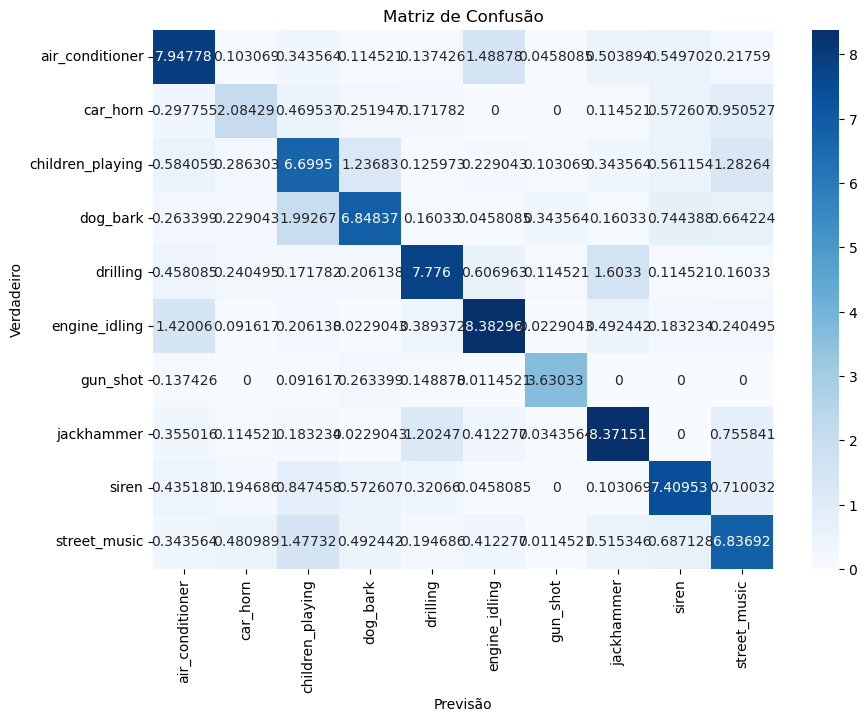

In [41]:
print(best_model.summary())
print("Learning rate: ", best_model_lr)
print("Number of epochs: ", best_model_epochs)
print("Batch Size: ", best_model_batch_size)
print("Accuracy: ", best_model_accuracy)
print("Loss: ", best_model_loss)

cm = pd.DataFrame(best_model_cfm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.show()

## Referências

https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c  
https://medium.com/thedeephub/learning-rate-and-its-strategies-in-neural-network-training-270a91ea0e5c  
https://www.kaggle.com/code/androbomb/simple-nn-with-python-multi-layer-perceptron  
https://medium.com/ensina-ai/rede-neural-perceptron-multicamadas-f9de8471f1a9  
https://iaexpert.academy/2020/05/04/quantas-camadas-escondidas-e-quantos-neuronios-incluir-numa-rede-neural-artificial/
https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c  
https://github.com/enochkan/building-from-scratch/blob/main/optimizers/adam-optimizer-from-scratch.ipynb  
https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/  
https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab  
https://stackoverflow.com/questions/60390707/how-to-choose-the-number-of-convolution-layers-and-filters-in-cnn  
https://machinelearningmastery.com/improve-deep-learning-performance/